In [ ]:
!pip install -U scopyon

In [2]:
import numpy
import os.path

In [3]:
from ecell4 import *
from ecell4_base.core import *
from ecell4_base import *

In [4]:
with species_attributes():
    X | {'D': 0.1e-12, 'location': 'M', 'dimension': 2}
    M | {'dimension': 2}

m = get_model()

show(m)

X|{'location': 'M', 'dimension': <ecell4_base.core.Quantity object at 0x153b195a6128>, 'D': <ecell4_base.core.Quantity object at 0x153b195a6198>}
M|{'dimension': <ecell4_base.core.Quantity object at 0x153b195a6198>}


In [5]:
f = spatiocyte.Factory(0.01e-6)

w = f.world(Real3(0.1e-6, 35e-6, 35e-6))
edge_lengths = w.edge_lengths()
w.bind_to(m)

# w.add_structure(Species('M'), PlanarSurface(Real3(0, 0, 0), unity(), unitz()))  # This causes the problem
w.add_structure(Species('M'), PlanarSurface(Real3(0.05e-6, 0, 0), unity(), unitz()))
w.add_molecules(Species('X'), 2400)

a coordinate, an index,
        a serial and lot of a molecule ID, a fluorophore ID,
        p_state (defaults to 1) and cyc_id (defaults to `inf`).

In [6]:
from scopyon.config import Config
from scopyon.epifm import EPIFMSimulator
from scopyon.image import convert_8bit, save_image, show_with_spots

In [7]:
!curl -LO https://raw.githubusercontent.com/ecell/scopyon/master/examples/defaults.ini

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2077  100  2077    0     0   6293      0 --:--:-- --:--:-- --:--:--  6274


In [8]:
!cat defaults.ini

[all]
psf_depth_cutoff = 1000e-9
shutter_switch = True
detector_dark_count = 0
image_resolution = 1.6e-07
fluorophore_type = 'Tetramethylrhodamine(TRITC)'
slit_size = 3.7e-05
photoblinking_a_off = 0.48
dichroic_mirror = 'FF562-Di03-25x36'
ADConverter_fpn_type = 'none'
ignore_open_errors = False
source_depth = 2e-05
fluorophore_radius = 20e-9
detector_pair_pulses = 0.0
detector_readout_noise = 100
detector_base_position = (-2.0, 0.5, 0.5)
psf_normalization = 1.0
ADConverter_fpn_count = 0.0
background_mean = 0.01
source_type = 'LASER'
detector_exposure_time = 0.1
ADConverter_fullwell = 800000
psf_max_wave_length = 1000e-9
shutter_start_time = 0.0
detector_image_size = (512, 512)
detector_qeff = 0.92
photoactivation_frac_preactivation = 0.0
background_switch = True
emission_switch = False
photobleaching_switch = True
source_flux_density = 40
excitation_switch = False
photobleaching_alpha = 0.73
photoblinking_switch = False
crosstalk_switch = False
detector_emgain = 300
shutter_end_time = 

In [9]:
rndseed = 0

exposure_time = 33e-3
t0, t1 = 0.0, exposure_time * 2
cmin, cmax = 1900, 2500
low, high = 0, 255
focal_point = (0.0, 0.5 * edge_lengths[1], 0.5 * edge_lengths[2])

In [10]:
points = numpy.array([
    [0, p.position()[1], p.position()[2], pid.serial(), pid.lot(), 1, 1, numpy.inf]
    for pid, p in w.list_particles(Species('X'))])
print(points)
input_data = [(w.t(), points)]

[[0.00000000e+00 1.87234692e-05 1.45100000e-05 ... 1.00000000e+00
  1.00000000e+00            inf]
 [0.00000000e+00 2.13735070e-05 2.34600000e-05 ... 1.00000000e+00
  1.00000000e+00            inf]
 [0.00000000e+00 8.33116438e-06 3.41300000e-05 ... 1.00000000e+00
  1.00000000e+00            inf]
 ...
 [0.00000000e+00 3.18004528e-05 1.63600000e-05 ... 1.00000000e+00
  1.00000000e+00            inf]
 [0.00000000e+00 2.70546336e-05 8.80000000e-06 ... 1.00000000e+00
  1.00000000e+00            inf]
 [0.00000000e+00 2.15640326e-05 3.09700000e-05 ... 1.00000000e+00
  1.00000000e+00            inf]]


In [11]:
config = Config(os.path.abspath('defaults.ini'))
config.set_epifm_shutter(start_time=0, end_time=t1)
config.set_epifm_detector(exposure_time=exposure_time, focal_point=focal_point)

rng = numpy.random.RandomState(rndseed)

sim = EPIFMSimulator(config, rng=rng)

/home/kaizu/.local/share/virtualenvs/python-eSbFG-Wg/lib/python3.6/site-packages/scopyon/epifm.py:216: UserWarning: The given wave length [6e-07] was ignored
  warnings.warn('The given wave length [{}] was ignored'.format(wave_length))


In [12]:
camera, true_data = sim.output_frame(input_data, 0, rng=rng)
bytedata = convert_8bit(camera[: , : , 1], cmin, cmax, low, high)

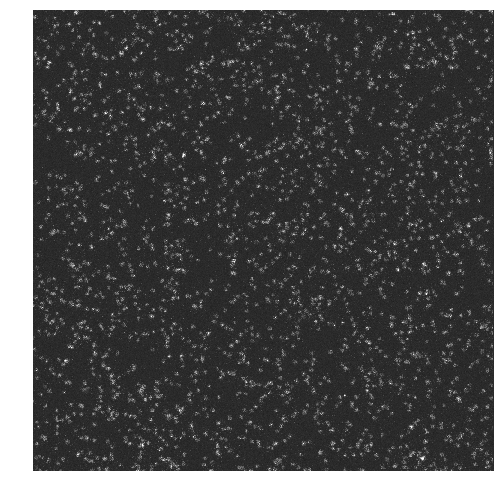

<Figure size 432x288 with 0 Axes>

In [13]:
save_image('samples_%07d.png' % (0), bytedata, low=low, high=high)

%matplotlib inline
import matplotlib.pylab as plt
show_with_spots(bytedata, low=low, high=high, dpi=80)